# Coronavirus Data Analysis

In [10]:
%matplotlib notebook

# Module to send http requests
from requests import get

import matplotlib.pyplot as plt
import pandas as pd

from datetime import date
import statistics as stats

In [11]:
def rolling_average(values, over):
    result = []
    for i in range(over-1):
        result.append(None)
    for i in range(len(values)-over+1):
        result.append(stats.mean(values[i:i+over]))
    return result

def get_data(url):
    response = get(endpoint, timeout=10)
    if response.status_code >= 400:
      raise RuntimeError(f'Request failed: { response.text }')
    return response.json()

In [12]:
def join_on_date(dfs):
    # Takes a dictionary of dataframes
    result = pd.DataFrame()
    for suffix, df in dfs.items():
        if result.empty:
            result = df.rename(columns={f"date{suffix.replace(' ','')}":'date'})
        else:
            result = result.merge(df, left_on='date', right_on=f"date{suffix.replace(' ','')}")
            result['date'].fillna(result[f"date{suffix.replace(' ','')}"], inplace=True)
            del result[f"date{suffix.replace(' ','')}"]
    result['date'] = result['date'].map(date.fromisoformat)
    return result

In [13]:
nations = ['England', 'Scotland', 'Wales', 'Northern Ireland']
populations = {'England':55.268E6, 
               'Scotland': 5.405E6, 
               'Wales': 3.113E6, 
               'Northern Ireland': 1.862E6}


nation_dfs = {}
for nation in nations:
    print(f'processing {nation}')
    endpoint = (
      'https://api.coronavirus.data.gov.uk/v1/data?'
      f'filters=areaType=nation;areaName={nation}&'
      'structure={"date":"date","newCases":"newCasesByPublishDate", "newDeaths":"newDeaths28DaysByPublishDate"}'
    )
    data = get_data(endpoint)
    nation_dfs[nation] = pd.DataFrame(data['data'])\
                                .sort_values('date')\
                                .reset_index(drop=True)\
                                .add_suffix(nation.replace(' ',''))


processing England
processing Scotland
processing Wales
processing Northern Ireland


In [14]:
joined_data_nations = join_on_date(nation_dfs)

In [15]:
joined_data_nations.to_csv('data_backup.csv')

<IPython.core.display.Javascript object>


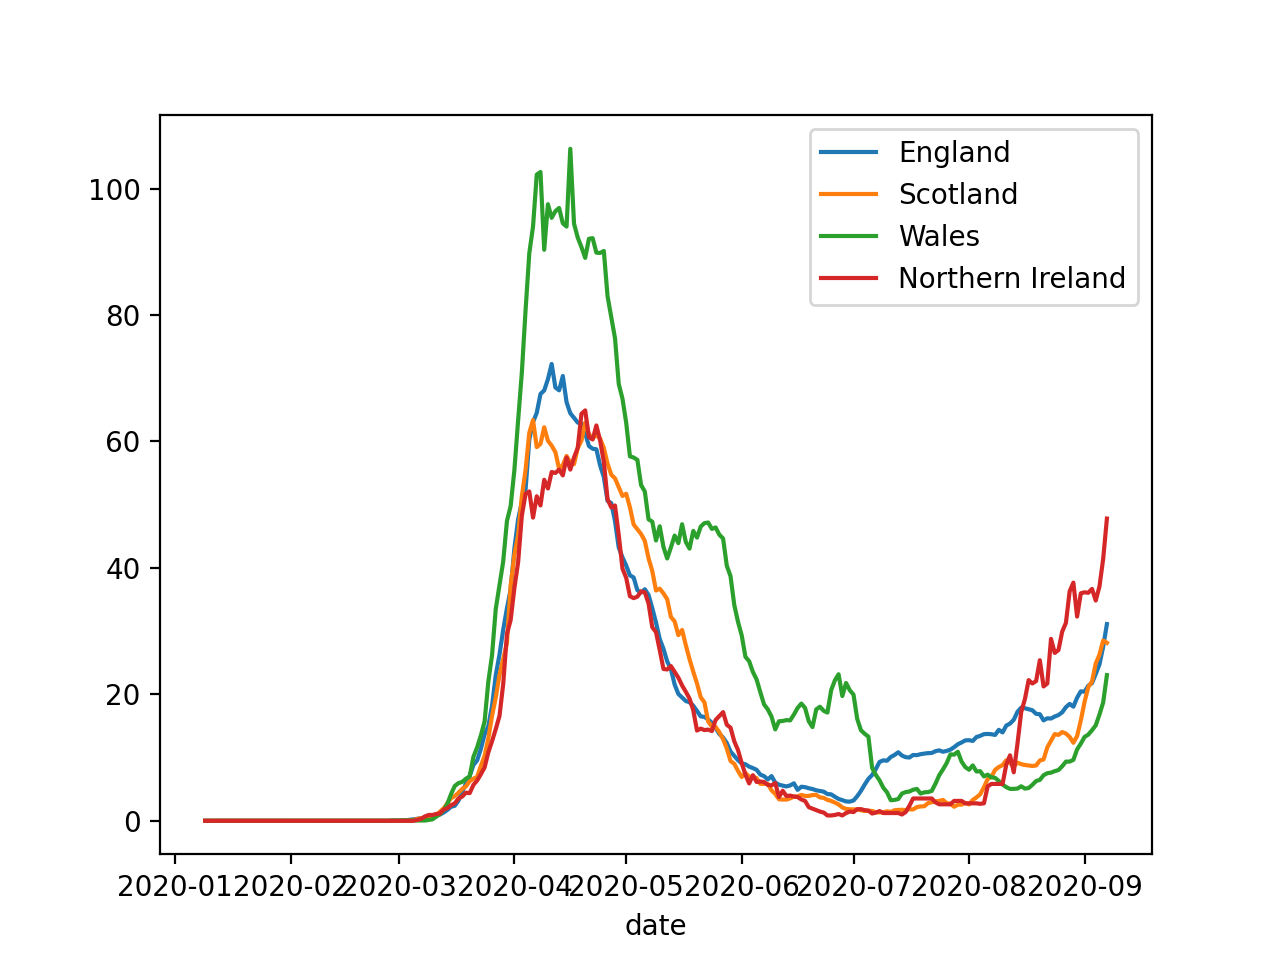

<IPython.core.display.Javascript object>


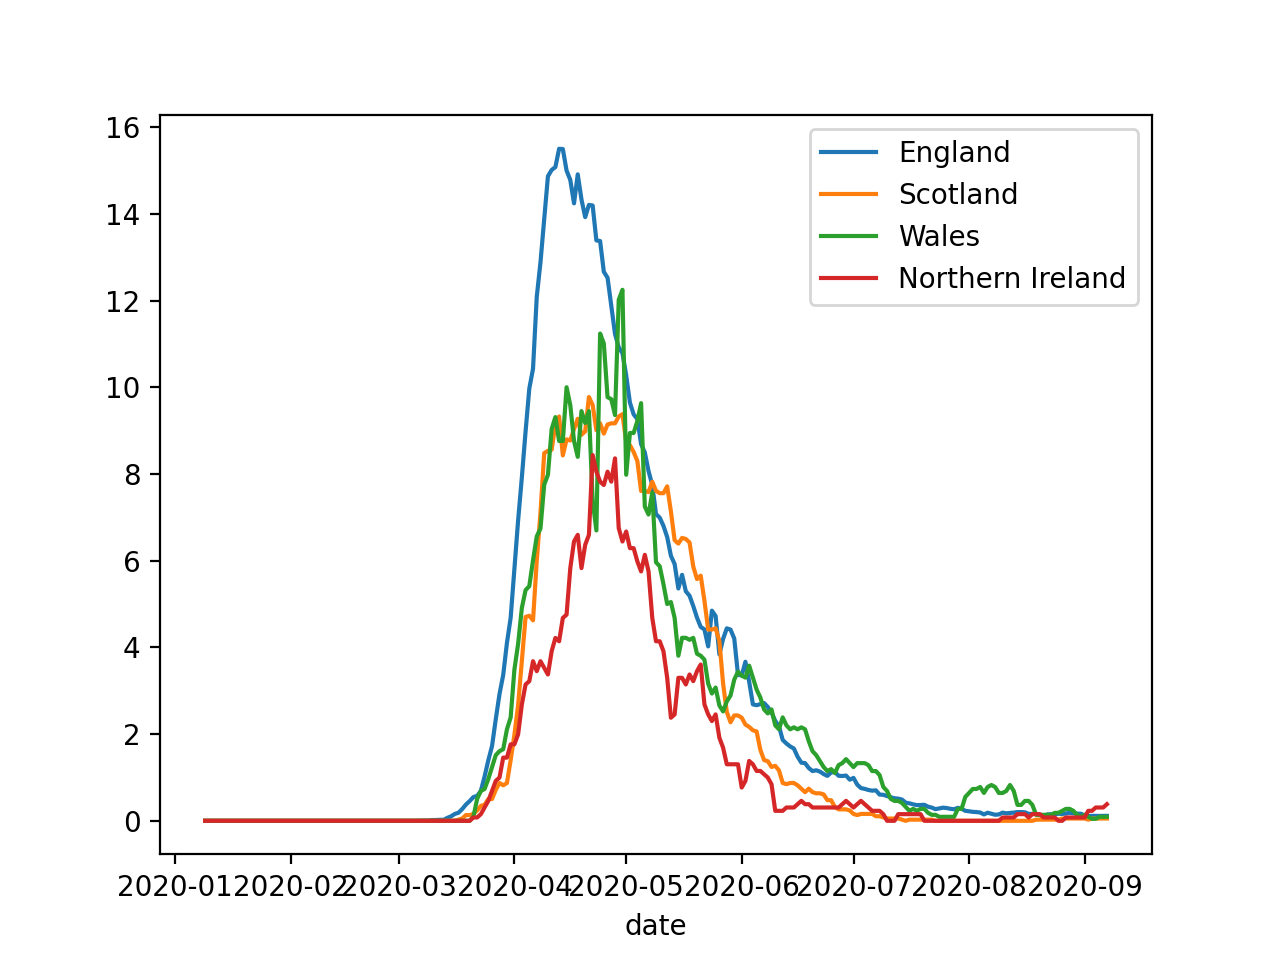

In [16]:
for nation in nations:
    joined_data_nations[f"newCasesPerMillion{nation.replace(' ','')}"] = joined_data_nations[f"newCases{nation.replace(' ','')}"]/(populations[nation]/10**6)
    joined_data_nations[f"newDeathsPerMillion{nation.replace(' ','')}"] = joined_data_nations[f"newDeaths{nation.replace(' ','')}"]/(populations[nation]/10**6)
    joined_data_nations[f"newCasesPerMillion7Day{nation.replace(' ','')}"] = rolling_average(joined_data_nations[f"newCasesPerMillion{nation.replace(' ','')}"],7)
    joined_data_nations[f"newDeathsPerMillion7Day{nation.replace(' ','')}"] = rolling_average(joined_data_nations[f"newDeathsPerMillion{nation.replace(' ','')}"],7)

newCasesList = [f"newCasesPerMillion7Day{nation.replace(' ','')}" for nation in nations]
newDeathsList =  [f"newDeathsPerMillion7Day{nation.replace(' ','')}" for nation in nations]

joined_data_nations.plot('date', newCasesList)
plt.legend(labels=nations)
joined_data_nations.plot('date', newDeathsList)
plt.legend(labels=nations)

In [17]:
utlas = ['Cheshire West and Chester','Leicester','Northumberland','North Yorkshire', 'Wirral', 'Oxfordshire', 'Cumbria']
populations = {'Cheshire West and Chester': 343071,
               'Leicester': 354224,
               'Northumberland': 322434,
               'North Yorkshire': 618054,
               'Wirral': 324011,
               'Oxfordshire': 691667,
               'Cumbria':496200}


utla_dfs = {}
for utla in utlas:
    print(f'processing {utla}')
    endpoint = (
      'https://api.coronavirus.data.gov.uk/v1/data?'
      f'filters=areaType=utla;areaName={utla}&'
      'structure={"date":"date","newCases":"newCasesBySpecimenDate", "newDeaths":"newDeaths28DaysByDeathDate"}'
    )
    data = get_data(endpoint)
    utla_dfs[utla] = pd.DataFrame(data['data'])\
                                .sort_values('date')\
                                .reset_index(drop=True)\
                                .add_suffix(utla.replace(' ',''))

processing Cheshire West and Chester
processing Leicester
processing Northumberland
processing North Yorkshire
processing Wirral
processing Oxfordshire
processing Cumbria


In [18]:
joined_data_utlas = join_on_date(utla_dfs)
joined_data_utlas.tail()

,date,newCasesCheshireWestandChester,newDeathsCheshireWestandChester,newCasesLeicester,newDeathsLeicester,newCasesNorthumberland,newDeathsNorthumberland,newCasesNorthYorkshire,newDeathsNorthYorkshire,newCasesWirral,newDeathsWirral,newCasesOxfordshire,newDeathsOxfordshire,newCasesCumbria,newDeathsCumbria
174,2020-09-03,7,None,21,None,10,None,21,None,16,None,14,None,7,None
175,2020-09-04,5,None,24,None,4,None,24,None,30,None,15,None,7,None
176,2020-09-05,8,None,10,None,7,None,10,None,13,None,15,None,6,None
177,2020-09-06,0,None,2,None,0,None,0,None,0,None,0,None,0,None
178,2020-09-07,0,None,0,None,0,None,0,None,0,None,0,None,0,None


<IPython.core.display.Javascript object>


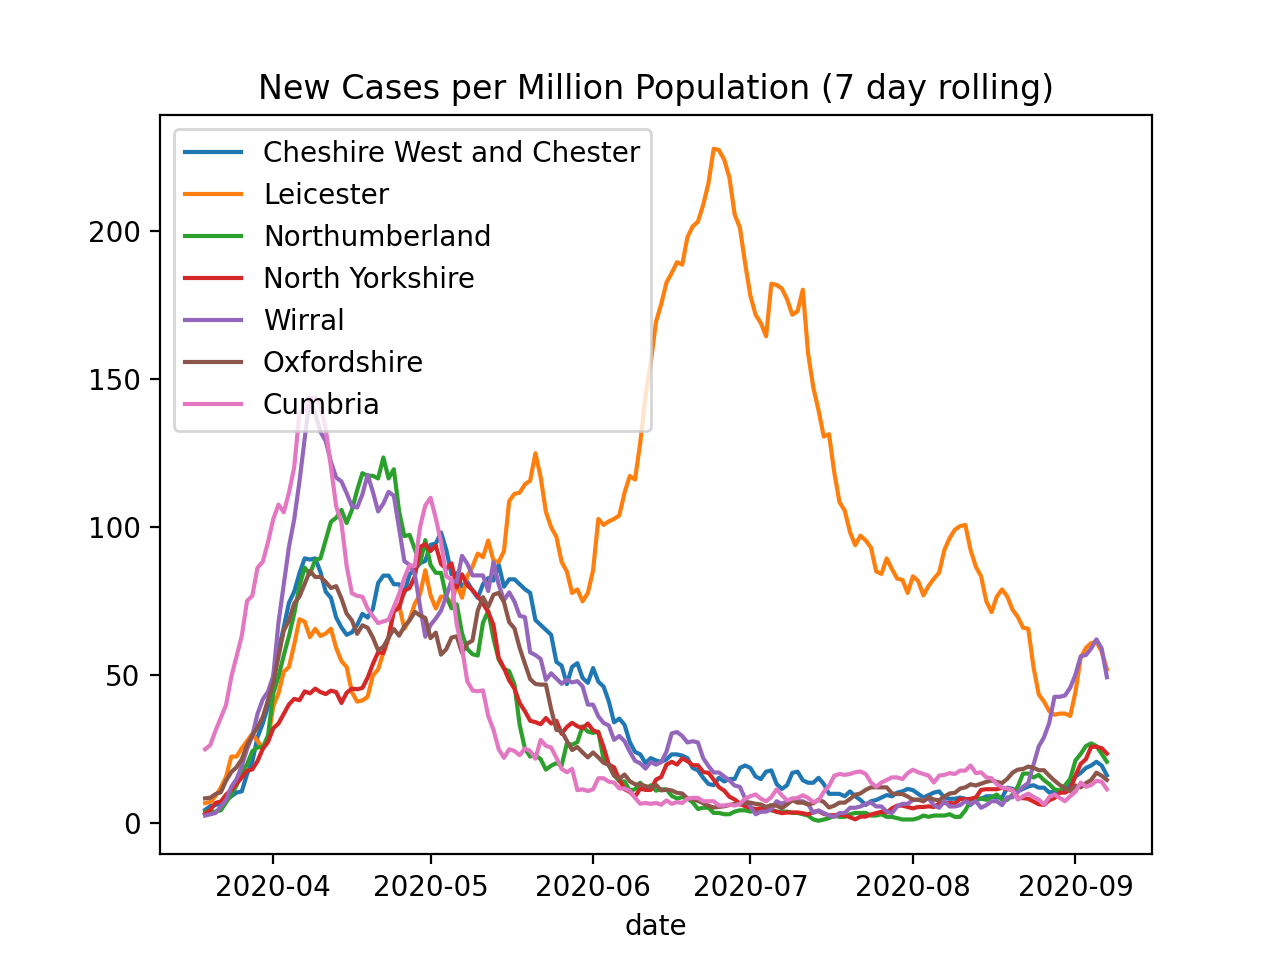

Text(0.5, 1.0, 'New Cases per Million Population (7 day rolling)')

In [19]:
for utla in utlas:
    joined_data_utlas[f"newCasesPerMillion{utla.replace(' ','')}"] = joined_data_utlas[f"newCases{utla.replace(' ','')}"]/(populations[utla]/10**6)
    joined_data_utlas[f"newCasesPerMillion7Day{utla.replace(' ','')}"] = rolling_average(joined_data_utlas[f"newCasesPerMillion{utla.replace(' ','')}"],7)

newCasesList = [f"newCasesPerMillion7Day{utla.replace(' ','')}" for utla in utlas]

joined_data_utlas.plot('date', newCasesList)
plt.legend(labels=utlas)
plt.title('New Cases per Million Population (7 day rolling)')